# Comprehensive Analysis of Missed Trash Pickups in Nashville

This notebook provides a complete analysis of service requests related to missed trash pickups from hubNashville. We will analyze damages, performance metrics, and create geospatial visualizations to understand patterns in the data.

## Key Objectives:
1. Calculate total damages due to missed pickups (accounting for duplicate addresses)
2. Analyze different types of complaints
3. Create heatmaps showing missed pickups and fines by zip code
4. Compare Metro crews vs contractor performance
5. Determine liability by trash hauler
6. Analyze performance by route

## 1. Setup and Library Imports

In [39]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Geospatial analysis
import geopandas as gpd
import folium
from folium.plugins import HeatMap, MarkerCluster
from pyproj import Proj, transform

# Statistical analysis
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("All libraries imported successfully!")

All libraries imported successfully!


## 2. Data Loading and Initial Exploration

In [40]:
# Load the dataset
df = pd.read_csv('missed_pickups.csv')

print(f"Dataset shape: {df.shape}")
print(f"Total records: {len(df):,}")
print("\nFirst few rows:")
df.head()

Dataset shape: (19057, 15)
Total records: 19,057

First few rows:


,Request_Number,Date_Opened,Request,Description,Incident_Address,Zip_Code,Trash_Hauler_x,Trash_Route,Council_District,State_Plan_X,State_Plan_Y,Trash_Hauler_y,missed_count,fines,Missed_by_Zip
0,25274,11/1/2017,Trash - Curbside/Alley Missed Pickup,Curb/Trash miss Tuesday.,4028 Clarksville Pike,37218.0,RED RIVER,4202,1.0,1721259.366,685444.7996,RED RIVER,2,200,962
1,25276,11/1/2017,Trash - Curbside/Alley Missed Pickup,Curb/trash miss Tuesday.,6528 Thunderbird Dr,37209.0,RED RIVER,4205,20.0,1707026.753,659887.4716,RED RIVER,1,0,1287
2,25307,11/1/2017,Trash - Curbside/Alley Missed Pickup,missed,2603 old matthews rd,37207.0,WASTE IND,2206,2.0,1735691.771,685027.2459,WASTE IND,1,0,1178
3,25312,11/1/2017,Trash - Curbside/Alley Missed Pickup,Missed the even side of the road.,604 croley dr,37209.0,RED RIVER,4203,20.0,1710185.772,664205.1011,RED RIVER,1,0,1287
4,25327,11/1/2017,Trash Collection Complaint,"Trash out on time, miss again Tuesday. ALLEY",1816 Jo Johnston Ave,37203.0,METRO,9208,21.0,1731459.367,666013.6012,METRO,2,200,392


In [41]:
# Dataset information
print("Dataset Info:")
df.info()
print("\n" + "="*50)
print("Column Descriptions:")
for col in df.columns:
    print(f"{col}: {df[col].dtype}")

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19057 entries, 0 to 19056
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Request_Number    19057 non-null  int64  
 1   Date_Opened       19057 non-null  object 
 2   Request           19057 non-null  object 
 3   Description       19028 non-null  object 
 4   Incident_Address  19030 non-null  object 
 5   Zip_Code          18979 non-null  float64
 6   Trash_Hauler_x    17917 non-null  object 
 7   Trash_Route       17891 non-null  object 
 8   Council_District  18999 non-null  float64
 9   State_Plan_X      19015 non-null  float64
 10  State_Plan_Y      19015 non-null  float64
 11  Trash_Hauler_y    17388 non-null  object 
 12  missed_count      19057 non-null  int64  
 13  fines             19057 non-null  int64  
 14  Missed_by_Zip     19057 non-null  int64  
dtypes: float64(4), int64(4), object(7)
memory usage: 2.2+ MB

Column Descript

In [42]:
# Basic statistics
print("Basic Statistics:")
df.describe(include='all')

Basic Statistics:


,Request_Number,Date_Opened,Request,Description,Incident_Address,Zip_Code,Trash_Hauler_x,Trash_Route,Council_District,State_Plan_X,State_Plan_Y,Trash_Hauler_y,missed_count,fines,Missed_by_Zip
count,19057.000000,19057,19057,19028,19030,18979.000000,17917,17891,18999.000000,1.901500e+04,1.901500e+04,17388,19057.000000,19057.000000,19057.000000
unique,NaN,682,3,10714,12647,NaN,3,172,NaN,NaN,NaN,3,NaN,NaN,NaN
top,NaN,8/2/2019,Trash - Curbside/Alley Missed Pickup,miss,5135 Hickory Hollow Pkwy,NaN,RED RIVER,4504,NaN,NaN,NaN,RED RIVER,NaN,NaN,NaN
freq,NaN,250,15916,936,42,NaN,13600,351,NaN,NaN,NaN,13144,NaN,NaN,NaN
mean,151202.173794,NaN,NaN,NaN,NaN,37179.713525,NaN,NaN,18.260487,1.760649e+06,6.590013e+05,NaN,2.061710,212.341922,1269.247048
std,71637.218197,NaN,NaN,NaN,NaN,67.377208,NaN,NaN,9.962235,7.230344e+05,4.160870e+04,NaN,2.109779,421.955758,583.043908
min,25274.000000,NaN,NaN,NaN,NaN,37013.000000,NaN,NaN,1.000000,1.663490e+06,-2.719106e+05,NaN,1.000000,0.000000,1.000000
25%,87591.000000,NaN,NaN,NaN,NaN,37205.000000,NaN,NaN,8.000000,1.727776e+06,6.402873e+05,NaN,1.000000,0.000000,934.000000
50%,149426.000000,NaN,NaN,NaN,NaN,37209.000000,NaN,NaN,20.000000,1.745817e+06,6.553223e+05,NaN,1.000000,0.000000,1178.000000
75%,218466.000000,NaN,NaN,NaN,NaN,37214.000000,NaN,NaN,26.000000,1.759720e+06,6.753330e+05,NaN,2.000000,200.000000,1415.000000


## 3. Data Quality Assessment and Cleaning

In [43]:
# Check for missing values
print("Missing Values Analysis:")
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Percentage': missing_percent
})
print(missing_df[missing_df['Missing Count'] > 0])

Missing Values Analysis:
                  Missing Count  Percentage
Description                  29    0.152175
Incident_Address             27    0.141680
Zip_Code                     78    0.409298
Trash_Hauler_x             1140    5.982054
Trash_Route                1166    6.118487
Council_District             58    0.304350
State_Plan_X                 42    0.220391
State_Plan_Y                 42    0.220391
Trash_Hauler_y             1669    8.757937


In [44]:
# Convert Date_Opened to datetime
df['Date_Opened'] = pd.to_datetime(df['Date_Opened'])

# Extract additional date features
df['Year'] = df['Date_Opened'].dt.year
df['Month'] = df['Date_Opened'].dt.month
df['Day_of_Week'] = df['Date_Opened'].dt.day_name()
df['Quarter'] = df['Date_Opened'].dt.quarter

print("Date features added successfully!")
print(f"Date range: {df['Date_Opened'].min()} to {df['Date_Opened'].max()}")

Date features added successfully!
Date range: 2017-11-01 00:00:00 to 2019-11-01 00:00:00


## 4. Total Damages Calculation (Accounting for Address Duplicates)

In [45]:
# Filter for actual missed pickup requests
missed_pickup_types = [
    'Trash - Curbside/Alley Missed Pickup',
    'Trash Collection Complaint',
     'Trash - Backdoor'
]

# Filter the data for missed pickups only
missed_pickups = df[df['Request'].isin(missed_pickup_types)].copy()

print(f"Total service requests: {len(df):,}")
print(f"Missed pickup requests: {len(missed_pickups):,}")
print(f"Percentage of missed pickups: {(len(missed_pickups)/len(df)*100):.1f}%")

Total service requests: 19,057
Missed pickup requests: 19,057
Percentage of missed pickups: 100.0%


In [46]:
# Calculate total damages properly accounting for address duplicates
# Group by address to get unique addresses and their total fines
address_fines = missed_pickups.groupby('Incident_Address').agg({
    'fines': 'max',  # Take the maximum fine value per address (to avoid double counting)
    'missed_count': 'max',  # Maximum missed count per address
    'Request_Number': 'count'  # Count of requests per address
}).rename(columns={'Request_Number': 'total_requests'})

# Calculate total damages
total_damages = address_fines['fines'].sum()

print(f"\n=== TOTAL DAMAGES CALCULATION ===")
print(f"Total unique addresses with missed pickups: {len(address_fines):,}")
print(f"Total damages owed: ${total_damages:,.2f}")
print(f"\nBreakdown:")
print(f"Addresses with no fines (first offense): {len(address_fines[address_fines['fines'] == 0]):,}")
print(f"Addresses with fines: {len(address_fines[address_fines['fines'] > 0]):,}")

# Show fine distribution
fine_distribution = address_fines[address_fines['fines'] > 0]['fines'].value_counts().sort_index()
print(f"\nFine Distribution:")
for fine_amount, count in fine_distribution.items():
    print(f"${fine_amount:,}: {count:,} addresses")


=== TOTAL DAMAGES CALCULATION ===
Total unique addresses with missed pickups: 12,647
Total damages owed: $942,800.00

Breakdown:
Addresses with no fines (first offense): 9,938
Addresses with fines: 2,709

Fine Distribution:
$200: 1,738 addresses
$400: 534 addresses
$600: 218 addresses
$800: 86 addresses
$1,000: 55 addresses
$1,200: 23 addresses
$1,400: 24 addresses
$1,600: 12 addresses
$1,800: 4 addresses
$2,000: 5 addresses
$2,200: 2 addresses
$2,400: 1 addresses
$2,800: 1 addresses
$3,000: 1 addresses
$3,200: 2 addresses
$3,400: 2 addresses
$3,600: 1 addresses


## 5. Analysis of Complaint Types

All Request Types:
Request
Trash - Curbside/Alley Missed Pickup    15916
Trash - Backdoor                         2332
Trash Collection Complaint                809
Name: count, dtype: int64


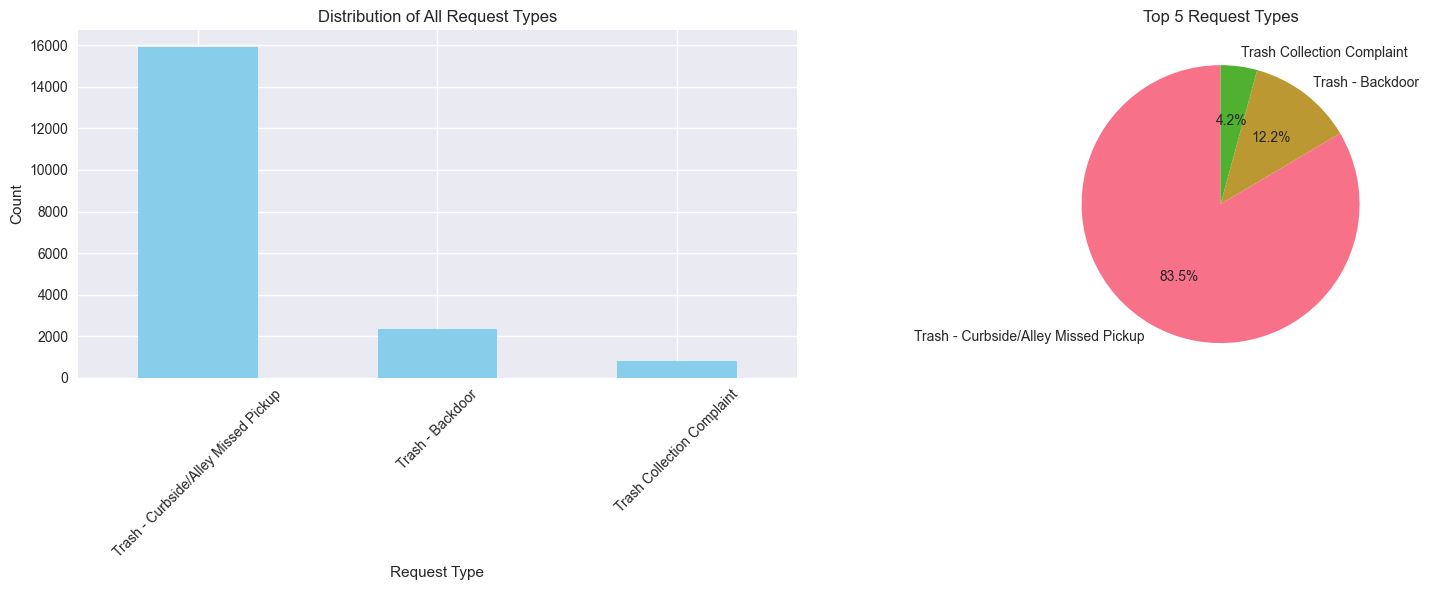

In [47]:
# Analyze all request types
request_types = df['Request'].value_counts()

print("All Request Types:")
print(request_types)

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart of request types
request_types.plot(kind='bar', ax=ax1, color='skyblue')
ax1.set_title('Distribution of All Request Types')
ax1.set_xlabel('Request Type')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

# Pie chart of top request types
top_requests = request_types.head(5)
ax2.pie(top_requests.values, labels=top_requests.index, autopct='%1.1f%%', startangle=90)
ax2.set_title('Top 5 Request Types')

plt.tight_layout()
plt.show()

## 6. Geospatial Data Preparation

In [48]:
# Convert State Plane coordinates to latitude/longitude
# Define the projection systems
in_proj = Proj(init='epsg:2274', preserve_units=True)  # NAD83 / Tennessee
out_proj = Proj(init='epsg:4326')  # WGS84

# Convert coordinates
missed_pickups['longitude'], missed_pickups['latitude'] = transform(
    in_proj, out_proj, 
    missed_pickups['State_Plan_X'].values, 
    missed_pickups['State_Plan_Y'].values
)

# Remove rows with missing location data
geo_data = missed_pickups.dropna(subset=['latitude', 'longitude']).copy()

print(f"Records with valid coordinates: {len(geo_data):,}")
print(f"Coordinate ranges:")
print(f"Latitude: {geo_data['latitude'].min():.4f} to {geo_data['latitude'].max():.4f}")
print(f"Longitude: {geo_data['longitude'].min():.4f} to {geo_data['longitude'].max():.4f}")

Records with valid coordinates: 19,015
Coordinate ranges:
Latitude: 0.0003 to 36.4670
Longitude: -87.0314 to -0.0008


## 7. Zip Code Analysis and Heatmaps

In [49]:
# Aggregate data by zip code
zip_analysis = geo_data.groupby('Zip_Code').agg({
    'Request_Number': 'count',
    'fines': 'sum',
    'missed_count': 'sum',
    'latitude': 'mean',
    'longitude': 'mean'
}).rename(columns={
    'Request_Number': 'total_requests',
    'fines': 'total_fines',
    'missed_count': 'total_missed_pickups'
})

# Sort by different metrics
print("Top 10 Zip Codes by Total Missed Pickups:")
print(zip_analysis.nlargest(10, 'total_requests')[['total_requests', 'total_fines', 'total_missed_pickups']])

print("\nTop 10 Zip Codes by Total Fines:")
print(zip_analysis.nlargest(10, 'total_fines')[['total_requests', 'total_fines', 'total_missed_pickups']])

Top 10 Zip Codes by Total Missed Pickups:
          total_requests  total_fines  total_missed_pickups
Zip_Code                                                   
37013.0             2242       538400                  4934
37211.0             2129       449400                  4376
37205.0             1415       391800                  3374
37215.0             1377       340800                  3081
37209.0             1287       302000                  2797
37207.0             1178       208000                  2218
37115.0             1167       285200                  2593
37206.0             1085       145200                  1811
37218.0              962       213200                  2028
37208.0              961       177000                  1846

Top 10 Zip Codes by Total Fines:
          total_requests  total_fines  total_missed_pickups
Zip_Code                                                   
37013.0             2242       538400                  4934
37211.0             2129

In [50]:
# Create interactive heatmap for missed pickups
nashville_center = [36.1627, -86.7816]

# Heatmap of all missed pickups
map_pickups = folium.Map(location=nashville_center, zoom_start=10)
heat_data_pickups = geo_data[['latitude', 'longitude']].values.tolist()
HeatMap(heat_data_pickups, radius=15).add_to(map_pickups)
map_pickups.save('comprehensive_missed_pickups_heatmap.html')

# Heatmap of fines (weighted by fine amount)
map_fines = folium.Map(location=nashville_center, zoom_start=10)
heat_data_fines = geo_data[geo_data['fines'] > 0][['latitude', 'longitude', 'fines']].values.tolist()
HeatMap(heat_data_fines, radius=15).add_to(map_fines)
map_fines.save('comprehensive_fines_heatmap.html')

print("Heatmaps created and saved:")
print("- comprehensive_missed_pickups_heatmap.html")
print("- comprehensive_fines_heatmap.html")

Heatmaps created and saved:
- comprehensive_missed_pickups_heatmap.html
- comprehensive_fines_heatmap.html


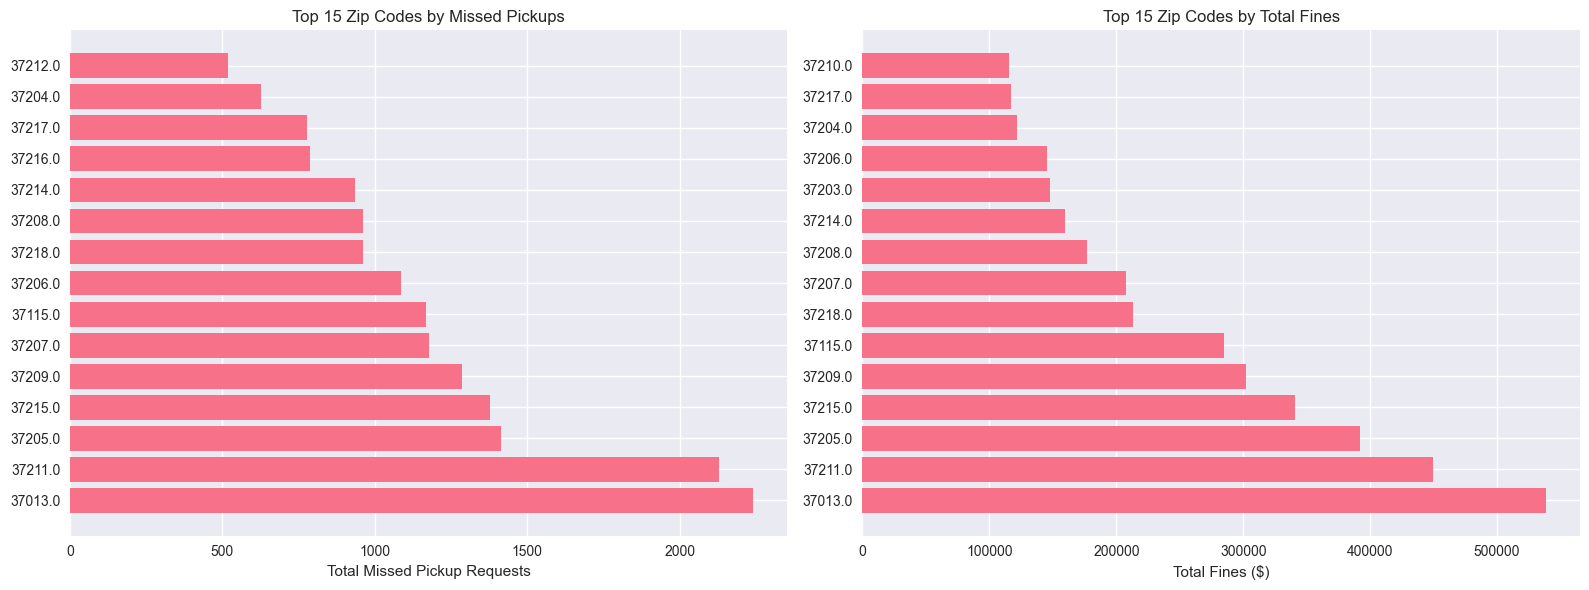

In [51]:
# Create zip code level visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Top zip codes by missed pickups
top_zips_pickups = zip_analysis.nlargest(15, 'total_requests')
ax1.barh(range(len(top_zips_pickups)), top_zips_pickups['total_requests'])
ax1.set_yticks(range(len(top_zips_pickups)))
ax1.set_yticklabels(top_zips_pickups.index)
ax1.set_xlabel('Total Missed Pickup Requests')
ax1.set_title('Top 15 Zip Codes by Missed Pickups')

# Top zip codes by fines
top_zips_fines = zip_analysis[zip_analysis['total_fines'] > 0].nlargest(15, 'total_fines')
ax2.barh(range(len(top_zips_fines)), top_zips_fines['total_fines'])
ax2.set_yticks(range(len(top_zips_fines)))
ax2.set_yticklabels(top_zips_fines.index)
ax2.set_xlabel('Total Fines ($)')
ax2.set_title('Top 15 Zip Codes by Total Fines')

plt.tight_layout()
plt.show()

## 8. Performance Comparison: Metro vs Contractors

In [52]:
# Analyze performance by trash hauler
hauler_performance = missed_pickups.groupby('Trash_Hauler_x').agg({
    'Request_Number': 'count',
    'fines': 'sum',
    'missed_count': 'sum',
    'Incident_Address': 'nunique'
}).rename(columns={
    'Request_Number': 'total_requests',
    'fines': 'total_fines_owed',
    'missed_count': 'total_missed_pickups',
    'Incident_Address': 'unique_addresses'
})

# Calculate performance metrics
hauler_performance['avg_missed_per_address'] = (hauler_performance['total_missed_pickups'] / 
                                               hauler_performance['unique_addresses'])
hauler_performance['fine_rate'] = (hauler_performance['total_fines_owed'] / 
                                  hauler_performance['total_requests'])

print("Performance Analysis by Trash Hauler:")
print(hauler_performance.round(2))

# Determine if Metro or contractors perform better
metro_performance = hauler_performance.loc['METRO']
contractor_performance = hauler_performance[hauler_performance.index != 'METRO']

print(f"\n=== METRO vs CONTRACTORS COMPARISON ===")
print(f"Metro fine rate: ${metro_performance['fine_rate']:.2f} per request")
print(f"Average contractor fine rate: ${contractor_performance['fine_rate'].mean():.2f} per request")
print(f"Metro avg missed per address: {metro_performance['avg_missed_per_address']:.2f}")
print(f"Average contractor missed per address: {contractor_performance['avg_missed_per_address'].mean():.2f}")

Performance Analysis by Trash Hauler:
                total_requests  total_fines_owed  total_missed_pickups  \
Trash_Hauler_x                                                           
METRO                     3159            610800                  6213   
RED RIVER                13600           3048800                 28844   
WASTE IND                 1158            173600                  2026   

                unique_addresses  avg_missed_per_address  fine_rate  
Trash_Hauler_x                                                       
METRO                       2230                    2.79     193.35  
RED RIVER                   9226                    3.13     224.18  
WASTE IND                    859                    2.36     149.91  

=== METRO vs CONTRACTORS COMPARISON ===
Metro fine rate: $193.35 per request
Average contractor fine rate: $187.05 per request
Metro avg missed per address: 2.79
Average contractor missed per address: 2.74


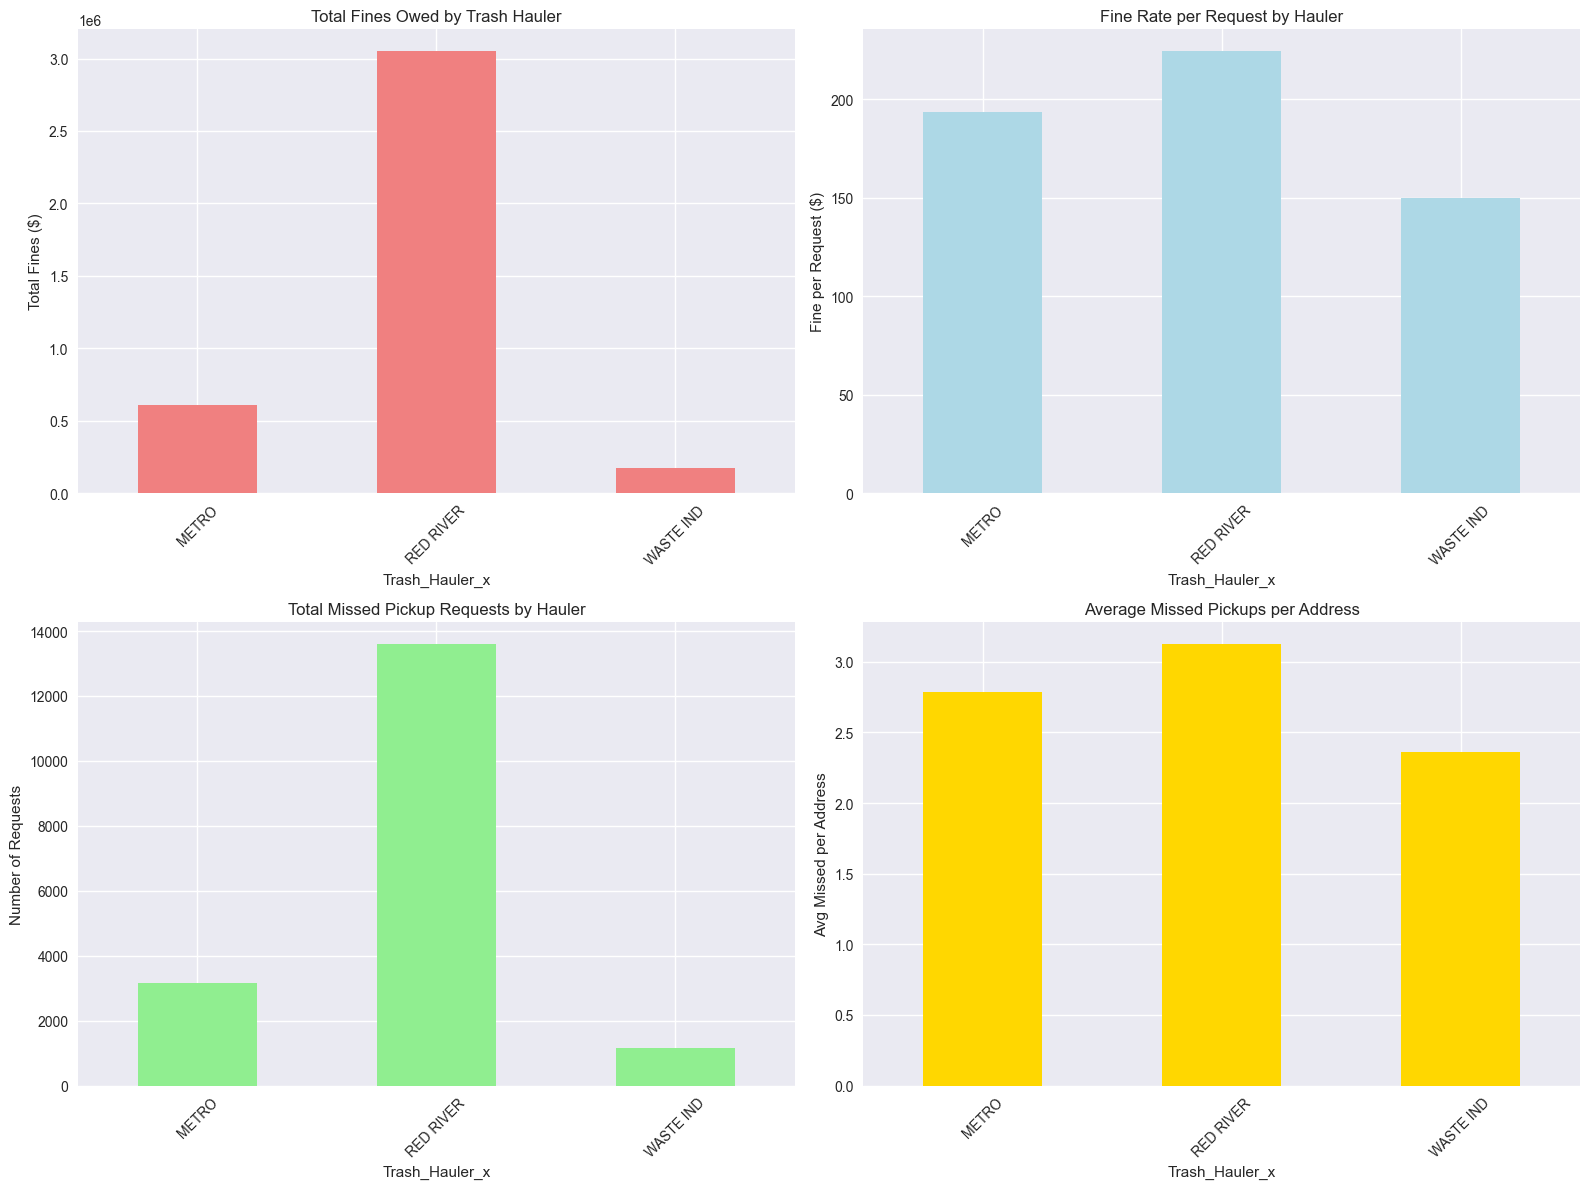

In [53]:
# Visualize hauler performance
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Total fines owed by hauler
hauler_performance['total_fines_owed'].plot(kind='bar', ax=ax1, color='lightcoral')
ax1.set_title('Total Fines Owed by Trash Hauler')
ax1.set_ylabel('Total Fines ($)')
ax1.tick_params(axis='x', rotation=45)

# Fine rate per request
hauler_performance['fine_rate'].plot(kind='bar', ax=ax2, color='lightblue')
ax2.set_title('Fine Rate per Request by Hauler')
ax2.set_ylabel('Fine per Request ($)')
ax2.tick_params(axis='x', rotation=45)

# Total requests by hauler
hauler_performance['total_requests'].plot(kind='bar', ax=ax3, color='lightgreen')
ax3.set_title('Total Missed Pickup Requests by Hauler')
ax3.set_ylabel('Number of Requests')
ax3.tick_params(axis='x', rotation=45)

# Average missed pickups per address
hauler_performance['avg_missed_per_address'].plot(kind='bar', ax=ax4, color='gold')
ax4.set_title('Average Missed Pickups per Address')
ax4.set_ylabel('Avg Missed per Address')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 9. Route Analysis

In [54]:
# Analyze performance by route
route_performance = missed_pickups.groupby(['Trash_Hauler_x', 'Trash_Route']).agg({
    'Request_Number': 'count',
    'fines': 'sum',
    'missed_count': 'sum',
    'Incident_Address': 'nunique'
}).rename(columns={
    'Request_Number': 'total_requests',
    'fines': 'total_fines',
    'missed_count': 'total_missed_pickups',
    'Incident_Address': 'unique_addresses'
})

# Calculate route efficiency metrics
route_performance['requests_per_address'] = (route_performance['total_requests'] / 
                                           route_performance['unique_addresses'])
route_performance['fine_per_request'] = (route_performance['total_fines'] / 
                                        route_performance['total_requests'])

print("Top 10 Routes by Total Missed Pickups:")
top_routes_missed = route_performance.nlargest(10, 'total_requests')
print(top_routes_missed[['total_requests', 'total_fines', 'unique_addresses']].round(2))

print("\nWorst 10 Routes by Fine per Request:")
worst_routes_fines = route_performance.nlargest(10, 'fine_per_request')
print(worst_routes_fines[['total_requests', 'fine_per_request', 'requests_per_address']].round(2))

Top 10 Routes by Total Missed Pickups:
                            total_requests  total_fines  unique_addresses
Trash_Hauler_x Trash_Route                                               
RED RIVER      4504                    351       129600               219
               3302                    320        78800               189
               4404                    264        55200               181
               1303                    263       101600               138
               3203                    261        79000               154
               1301                    257        57800               159
METRO          9303                    255        84000               152
RED RIVER      3305                    251        63600               154
               4304                    246        66800               153
               3201                    243        68000               155

Worst 10 Routes by Fine per Request:
                            total_r

## 10. Time Series Analysis

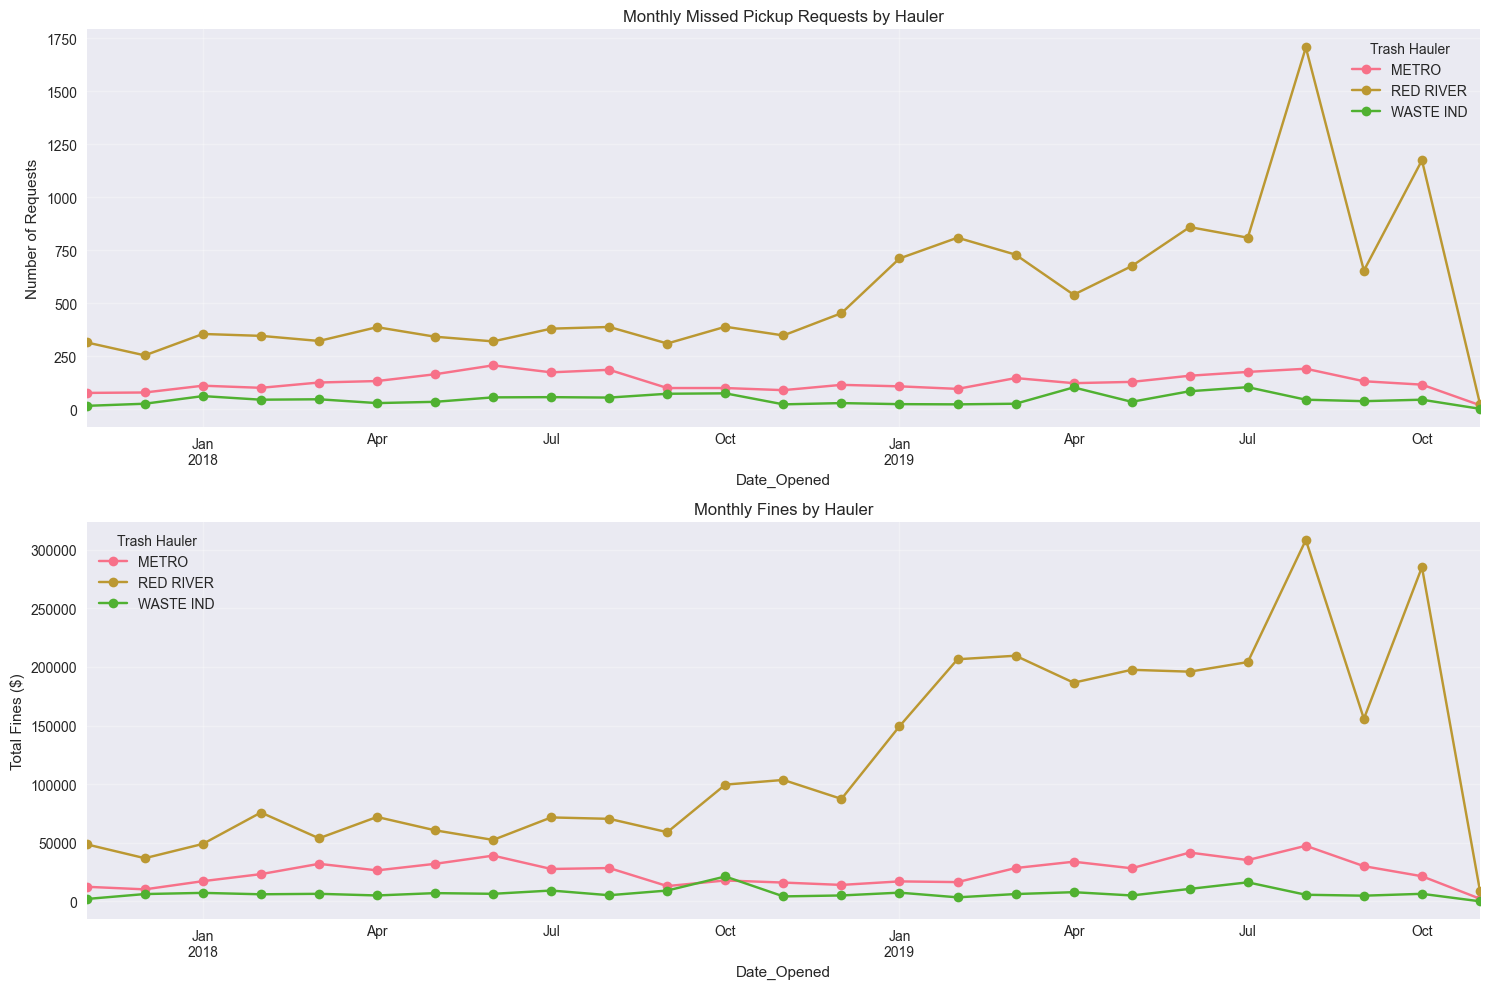

In [55]:
# Analyze trends over time
monthly_trends = missed_pickups.groupby([missed_pickups['Date_Opened'].dt.to_period('M'), 'Trash_Hauler_x']).agg({
    'Request_Number': 'count',
    'fines': 'sum'
}).unstack(fill_value=0)

# Plot monthly trends
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Monthly missed pickup requests
monthly_trends['Request_Number'].plot(ax=ax1, marker='o')
ax1.set_title('Monthly Missed Pickup Requests by Hauler')
ax1.set_ylabel('Number of Requests')
ax1.legend(title='Trash Hauler')
ax1.grid(True, alpha=0.3)

# Monthly fines
monthly_trends['fines'].plot(ax=ax2, marker='o')
ax2.set_title('Monthly Fines by Hauler')
ax2.set_ylabel('Total Fines ($)')
ax2.legend(title='Trash Hauler')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Executive Summary and Key Insights

In [56]:
# Generate executive summary
print("\n" + "="*60)
print("EXECUTIVE SUMMARY - MISSED TRASH PICKUPS ANALYSIS")
print("="*60)

print(f"\n📊 OVERALL STATISTICS:")
print(f"   • Total service requests analyzed: {len(df):,}")
print(f"   • Missed pickup requests: {len(missed_pickups):,}")
print(f"   • Unique addresses affected: {missed_pickups['Incident_Address'].nunique():,}")
print(f"   • Date range: {df['Date_Opened'].min().strftime('%B %Y')} to {df['Date_Opened'].max().strftime('%B %Y')}")

print(f"\n💰 FINANCIAL IMPACT:")
print(f"   • Total damages owed: ${total_damages:,.2f}")
print(f"   • Addresses subject to fines: {len(address_fines[address_fines['fines'] > 0]):,}")
print(f"   • Average fine per penalized address: ${address_fines[address_fines['fines'] > 0]['fines'].mean():,.2f}")

print(f"\n🚛 HAULER PERFORMANCE:")
for hauler in hauler_performance.index:
    hp = hauler_performance.loc[hauler]
    print(f"   • {hauler}: ${hp['total_fines_owed']:,.2f} owed, {hp['total_requests']:,} requests, ${hp['fine_rate']:.2f} per request")

print(f"\n📍 GEOGRAPHIC INSIGHTS:")
top_zip = zip_analysis.nlargest(1, 'total_requests').index[0]
top_zip_data = zip_analysis.loc[top_zip]
print(f"   • Highest impact zip code: {top_zip} ({top_zip_data['total_requests']:,} requests, ${top_zip_data['total_fines']:,.2f} fines)")

worst_route = route_performance.nlargest(1, 'total_requests').index[0]
worst_route_data = route_performance.loc[worst_route]
print(f"   • Most problematic route: {worst_route[0]} Route {worst_route[1]} ({worst_route_data['total_requests']:,} requests)")

print(f"\n🎯 KEY RECOMMENDATIONS:")
print(f"   1. Focus improvement efforts on zip code {top_zip} and similar high-impact areas")
print(f"   2. Investigate Route {worst_route[1]} operations for {worst_route[0]}")
print(f"   3. Implement targeted interventions for addresses with multiple violations")
print(f"   4. Monitor contractor performance against Metro baseline")

print("\n" + "="*60)


EXECUTIVE SUMMARY - MISSED TRASH PICKUPS ANALYSIS

📊 OVERALL STATISTICS:
   • Total service requests analyzed: 19,057
   • Missed pickup requests: 19,057
   • Unique addresses affected: 12,647
   • Date range: November 2017 to November 2019

💰 FINANCIAL IMPACT:
   • Total damages owed: $942,800.00
   • Addresses subject to fines: 2,709
   • Average fine per penalized address: $348.03

🚛 HAULER PERFORMANCE:
   • METRO: $610,800.00 owed, 3,159.0 requests, $193.35 per request
   • RED RIVER: $3,048,800.00 owed, 13,600.0 requests, $224.18 per request
   • WASTE IND: $173,600.00 owed, 1,158.0 requests, $149.91 per request

📍 GEOGRAPHIC INSIGHTS:
   • Highest impact zip code: 37013.0 (2,242.0 requests, $538,400.00 fines)
   • Most problematic route: RED RIVER Route 4504 (351.0 requests)

🎯 KEY RECOMMENDATIONS:
   1. Focus improvement efforts on zip code 37013.0 and similar high-impact areas
   2. Investigate Route 4504 operations for RED RIVER
   3. Implement targeted interventions for addr

## 12. Export Results

In [57]:
# Export key results to CSV files
hauler_performance.to_csv('hauler_performance_analysis.csv')
zip_analysis.to_csv('zip_code_analysis.csv')
route_performance.to_csv('route_performance_analysis.csv')
address_fines.to_csv('address_fines_summary.csv')

print("Analysis complete! Exported files:")
print("• hauler_performance_analysis.csv")
print("• zip_code_analysis.csv")
print("• route_performance_analysis.csv")
print("• address_fines_summary.csv")
print("• comprehensive_missed_pickups_heatmap.html")
print("• comprehensive_fines_heatmap.html")

Analysis complete! Exported files:
• hauler_performance_analysis.csv
• zip_code_analysis.csv
• route_performance_analysis.csv
• address_fines_summary.csv
• comprehensive_missed_pickups_heatmap.html
• comprehensive_fines_heatmap.html
